In [1]:
import os
import glob
import math
import pickle
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
INT_S2_DIR = sorted([d for d in glob.glob("_intermediate/stage2_pathology_masked/*") if os.path.isdir(d)])[-1]

In [3]:
INT_S2_DIR

'_intermediate/stage2_pathology_masked/2024_11_25_10_29_26'

In [4]:
names = [d for d in os.listdir(INT_S2_DIR) if os.path.isdir(os.path.join(INT_S2_DIR, d))]

In [5]:
names

['(SAM + YOLOv8) + (InceptionV3)',
 '(YOLOv8) + (VGG19)',
 '(SAM + YOLOv8) + (ResNet152V2)',
 '(YOLOv8) + (ResNet152V2)',
 '(YOLOv8) + (AlexNet)',
 '(SAM + ResNet) + (ResNet152V2)',
 '(SAM + ResNet) + (VGG19)',
 '(SAM + ResNet) + (InceptionV3)',
 '(SAM + YOLOv8) + (AlexNet)',
 '(SAM + YOLOv8) + (VGG19)',
 '(YOLOv8) + (InceptionV3)',
 '(SAM + ResNet) + (AlexNet)']

In [6]:
def select_leaves_area_k(data, k=1, offset=0):
    preds, masks = data
    ma_all = sorted(range(len(masks)), key=lambda k: masks[k]['patch'].shape[0] * masks[k]['patch'].shape[1])
    if offset == 0:
        ma_index = ma_all[-k:]
    else:
        ma_index = ma_all[-(k+offset):-offset]
    if k >= len(ma_all):
        ma_index = ma_all
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [64]:
def select_leaves_area(data, threshold=1_280):
    preds, masks = data
    indices = [i for i, mask in enumerate(masks) if mask['patch'].shape[0] * mask['patch'].shape[1] > threshold]
    preds = [data[0][i] for i in indices]
    masks = [data[1][i] for i in indices]
    return preds, masks

In [65]:
def select_leaves_area_relative(data, ratio):
    preds, masks = data
    if len(masks) == 0:
        return preds, masks
    image_area = masks[0]['segmentation'].shape[0] * masks[0]['segmentation'].shape[1]
    indices = [i for i, mask in enumerate(masks) if mask['patch'].shape[0] * mask['patch'].shape[1] > image_area * ratio]
    preds = [data[0][i] for i in indices]
    masks = [data[1][i] for i in indices]
    return preds, masks

In [8]:
def select_leaves_all(data):
    preds, masks = data
    return preds, masks

In [9]:
def select_leaves_probability_k(data, k=1):
    preds, masks = data
    for i, mask in enumerate(masks):
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
    ma_index = sorted(range(len(masks)), key=lambda k: masks[k]['leaf_probability'])[-k:]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

In [10]:
def select_leaves_probability(data, threshold=.9):
    masks = []
    preds = []
    for i, mask in enumerate(data[1]):
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
        if mask['leaf_probability'] < threshold:
            continue
        masks.append(mask)
        preds.append(data[0][i])
    return preds, masks

In [11]:
def select_leaves_combined(data, k=1):
    preds, masks = data
    for i, mask in enumerate(masks):
        try:
            len(mask['leaf_probability'])
        except TypeError:
            pass
        else:
             mask['leaf_probability'] = mask['leaf_probability'][0]
    def score(k):
        return math.sqrt(math.sqrt(masks[k]['patch'].shape[0] * masks[k]['patch'].shape[1])) * masks[k]['leaf_probability']
    ma_index = sorted(range(len(masks)), key=score)[-k:]
    ma_preds = [preds[i] for i in ma_index]
    ma_masks = [masks[i] for i in ma_index]
    return ma_preds, ma_masks

(SAM + YOLOv8) + (InceptionV3)
26
[0.9316482]
False
(YOLOv8) + (VGG19)
1
[0.5619548]
False
(SAM + YOLOv8) + (ResNet152V2)
26
[0.34965825]
False
(YOLOv8) + (ResNet152V2)
1
[0.0010997459]
False
(YOLOv8) + (AlexNet)
1
[0.031960968]
False
(SAM + ResNet) + (ResNet152V2)
26
[2.0363022e-06]
False
(SAM + ResNet) + (VGG19)
26
[0.97216445]
False
(SAM + ResNet) + (InceptionV3)
26
[0.9859995]
False
(SAM + YOLOv8) + (AlexNet)
26
[0.011712147]
False
(SAM + YOLOv8) + (VGG19)
26
[0.18419676]
False
(YOLOv8) + (InceptionV3)
1
[0.9881215]
False
(SAM + ResNet) + (AlexNet)
26
[0.12502262]
False


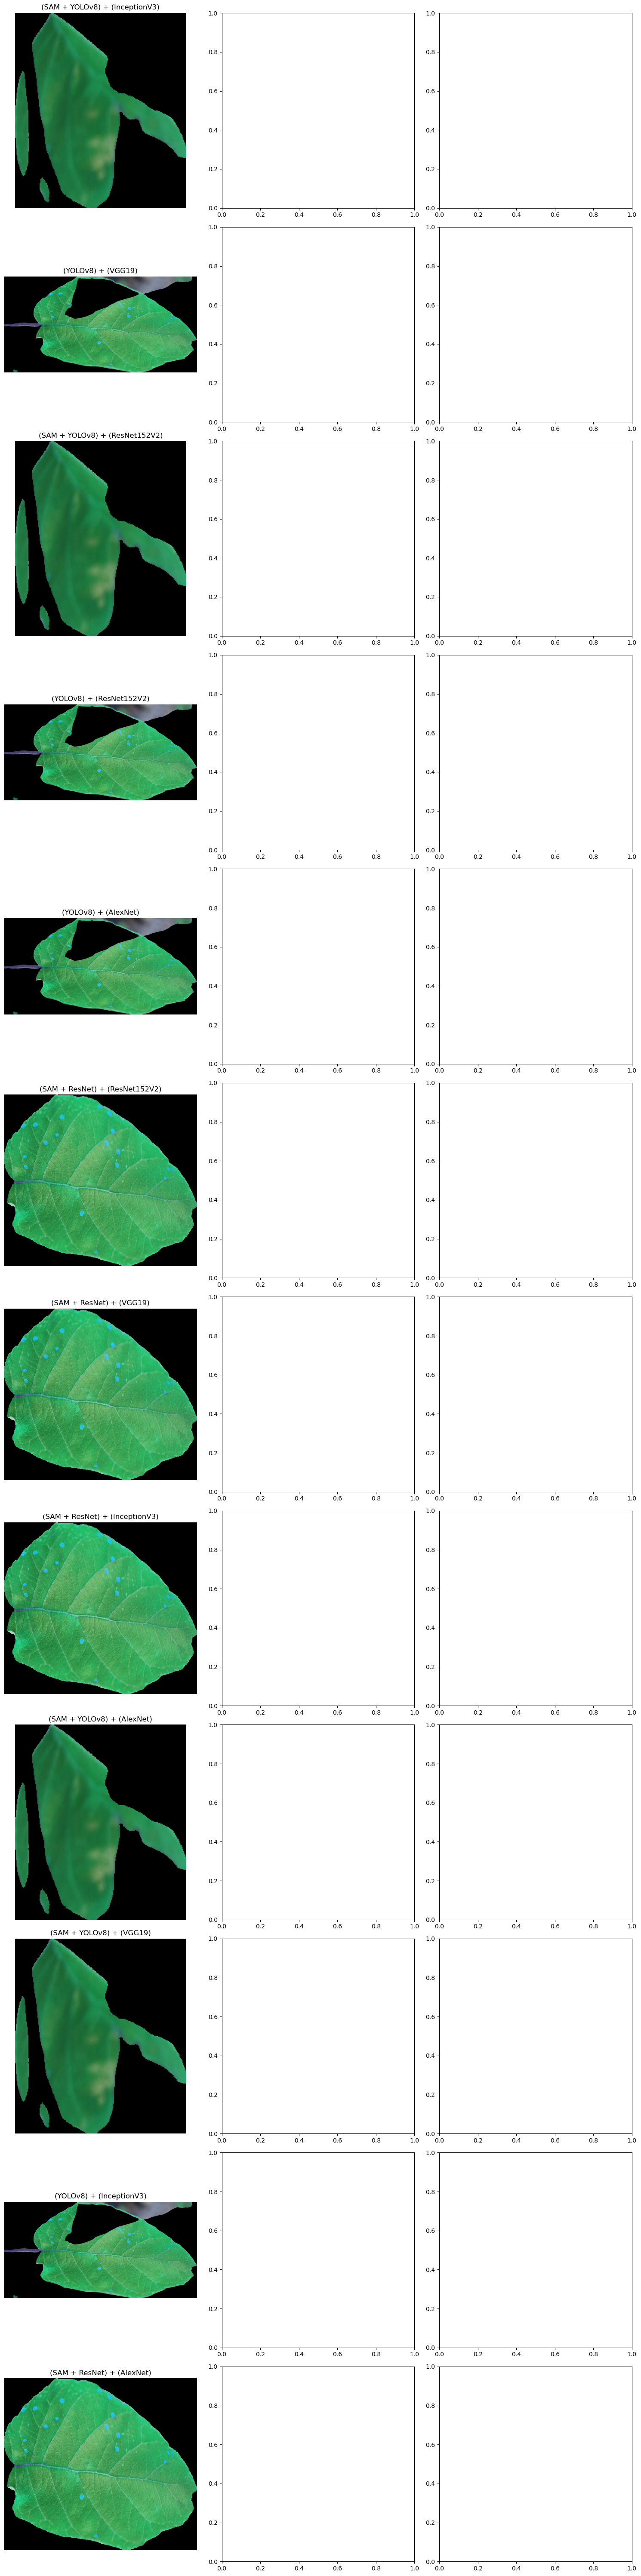

In [12]:
k = 3
fig, axes = plt.subplots(len(names), k, figsize=(15, 5 * len(names)))  # Adjust figure size
axes = np.array(axes).reshape(len(names), k)  # Ensure axes are in a 2D array if len(names) == 1

# Sample a single image_id to be used across all iterations
with open(os.path.join(INT_S2_DIR, names[0], "data.pkl"), "rb") as file:
    first_result = pickle.load(file)
image_id = random.sample(list(first_result.keys()), k=1)[0]
del first_result

for axs, name in zip(axes, names):
    print(name)
    with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
        result = pickle.load(file)
    print(len(result[image_id]['masks']))
    # Use the pre-selected image_id
    selected = select_leaves_probability((result[image_id]['predictions'], result[image_id]['masks']), .95)
    selected = select_leaves_area_k(selected, k=1, offset=1)
    amount = len(selected[0])
    print(selected[0])
    print(result[image_id]['healthy'])

    # Draw subplots
    for ax, mask in zip(axs, selected[1]):
        ax.imshow(mask['patch'])
        ax.axis('off')
        ax.set_title(name)
    # Set title for each subfigure

plt.tight_layout()
plt.show()

In [90]:
results_conv = {}
DISEASED_THRESHOLD = 1.94
DISEASED_THRESHOLD_SINGLE = .9
k = 3

p_bar = tqdm(names)
for name in p_bar:
    p_bar.set_description("Unpickling " + name)
    with open(os.path.join(INT_S2_DIR, name, "data.pkl"), "rb") as file:
        result = pickle.load(file)
    p_bar.set_description("Converting " + name)
    results_conv[name] = {
        'y_true': [],
        'y_pred': []
    }
    for image_id, data in result.items():
        if len(data['masks']) == 0:
            continue
        selected = (data['predictions'], data['masks'])
        selected = select_leaves_probability(selected, .9)
        selected = select_leaves_area_relative(selected, .6)
#        selected = select_leaves_area_k(selected, k=2)
#        pred = sum(selected[0])
#        results_conv[name]['y_pred'].append(int(pred < DISEASED_THRESHOLD))
#        results_conv[name]['y_true'].append(1 - int(data['healthy']))
#        continue
        for pred, mask in zip(selected[0], selected[1]):
            results_conv[name]['y_pred'].append(int(mask['prob_diseased'] < DISEASED_THRESHOLD_SINGLE))
            results_conv[name]['y_true'].append(1 - int(data['healthy']))
    if len(results_conv[name]['y_true']) == 0:
        print(f"{name} has no results")
        del results_conv[name]
    del result

Converting (SAM + ResNet) + (AlexNet): 100%|██████████| 12/12 [02:09<00:00, 10.79s/it]   


In [67]:
for name, data in results_conv.items():
    print(name, len(data['y_pred']))

(SAM + YOLOv8) + (InceptionV3) 616
(YOLOv8) + (VGG19) 388
(SAM + YOLOv8) + (ResNet152V2) 616
(YOLOv8) + (ResNet152V2) 388
(YOLOv8) + (AlexNet) 388
(SAM + ResNet) + (ResNet152V2) 884
(SAM + ResNet) + (VGG19) 884
(SAM + ResNet) + (InceptionV3) 884
(SAM + YOLOv8) + (AlexNet) 616
(SAM + YOLOv8) + (VGG19) 616
(YOLOv8) + (InceptionV3) 388
(SAM + ResNet) + (AlexNet) 884


In [15]:
import pickle
with open(os.path.join("_intermediate", "results_conv_masked.pkl"), "wb+") as file:
          pickle.dump(results_conv, file)

In [16]:
import pickle
with open(os.path.join("_intermediate", "results_conv.pkl"), "rb") as file:
        results_conv = pickle.load(file)

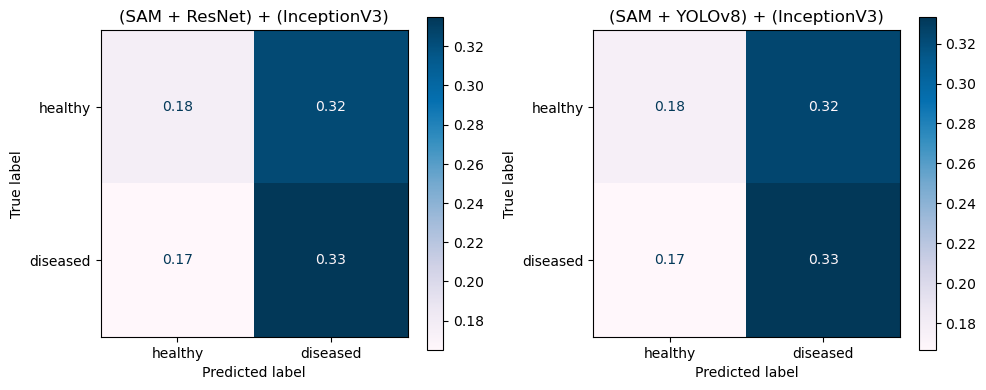

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
results_conv_filtered = {key:value for key, value in results_conv.items() if key == "(SAM + ResNet) + (InceptionV3)" or key == "(SAM + YOLOv8) + (InceptionV3)"}

cols = 2
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes = axes.flatten()

for ax, (name, data) in zip(axes, sorted(results_conv_filtered.items())):
    total = len(data['y_true'])
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    disp = ConfusionMatrixDisplay.from_predictions(data['y_true'], data['y_pred'],
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   sample_weight=sample_weight, 
                                                   normalize='all',
                                                   display_labels=["healthy", 'diseased'])
    disp.ax_.set_title(name)
plt.tight_layout()
plt.show()

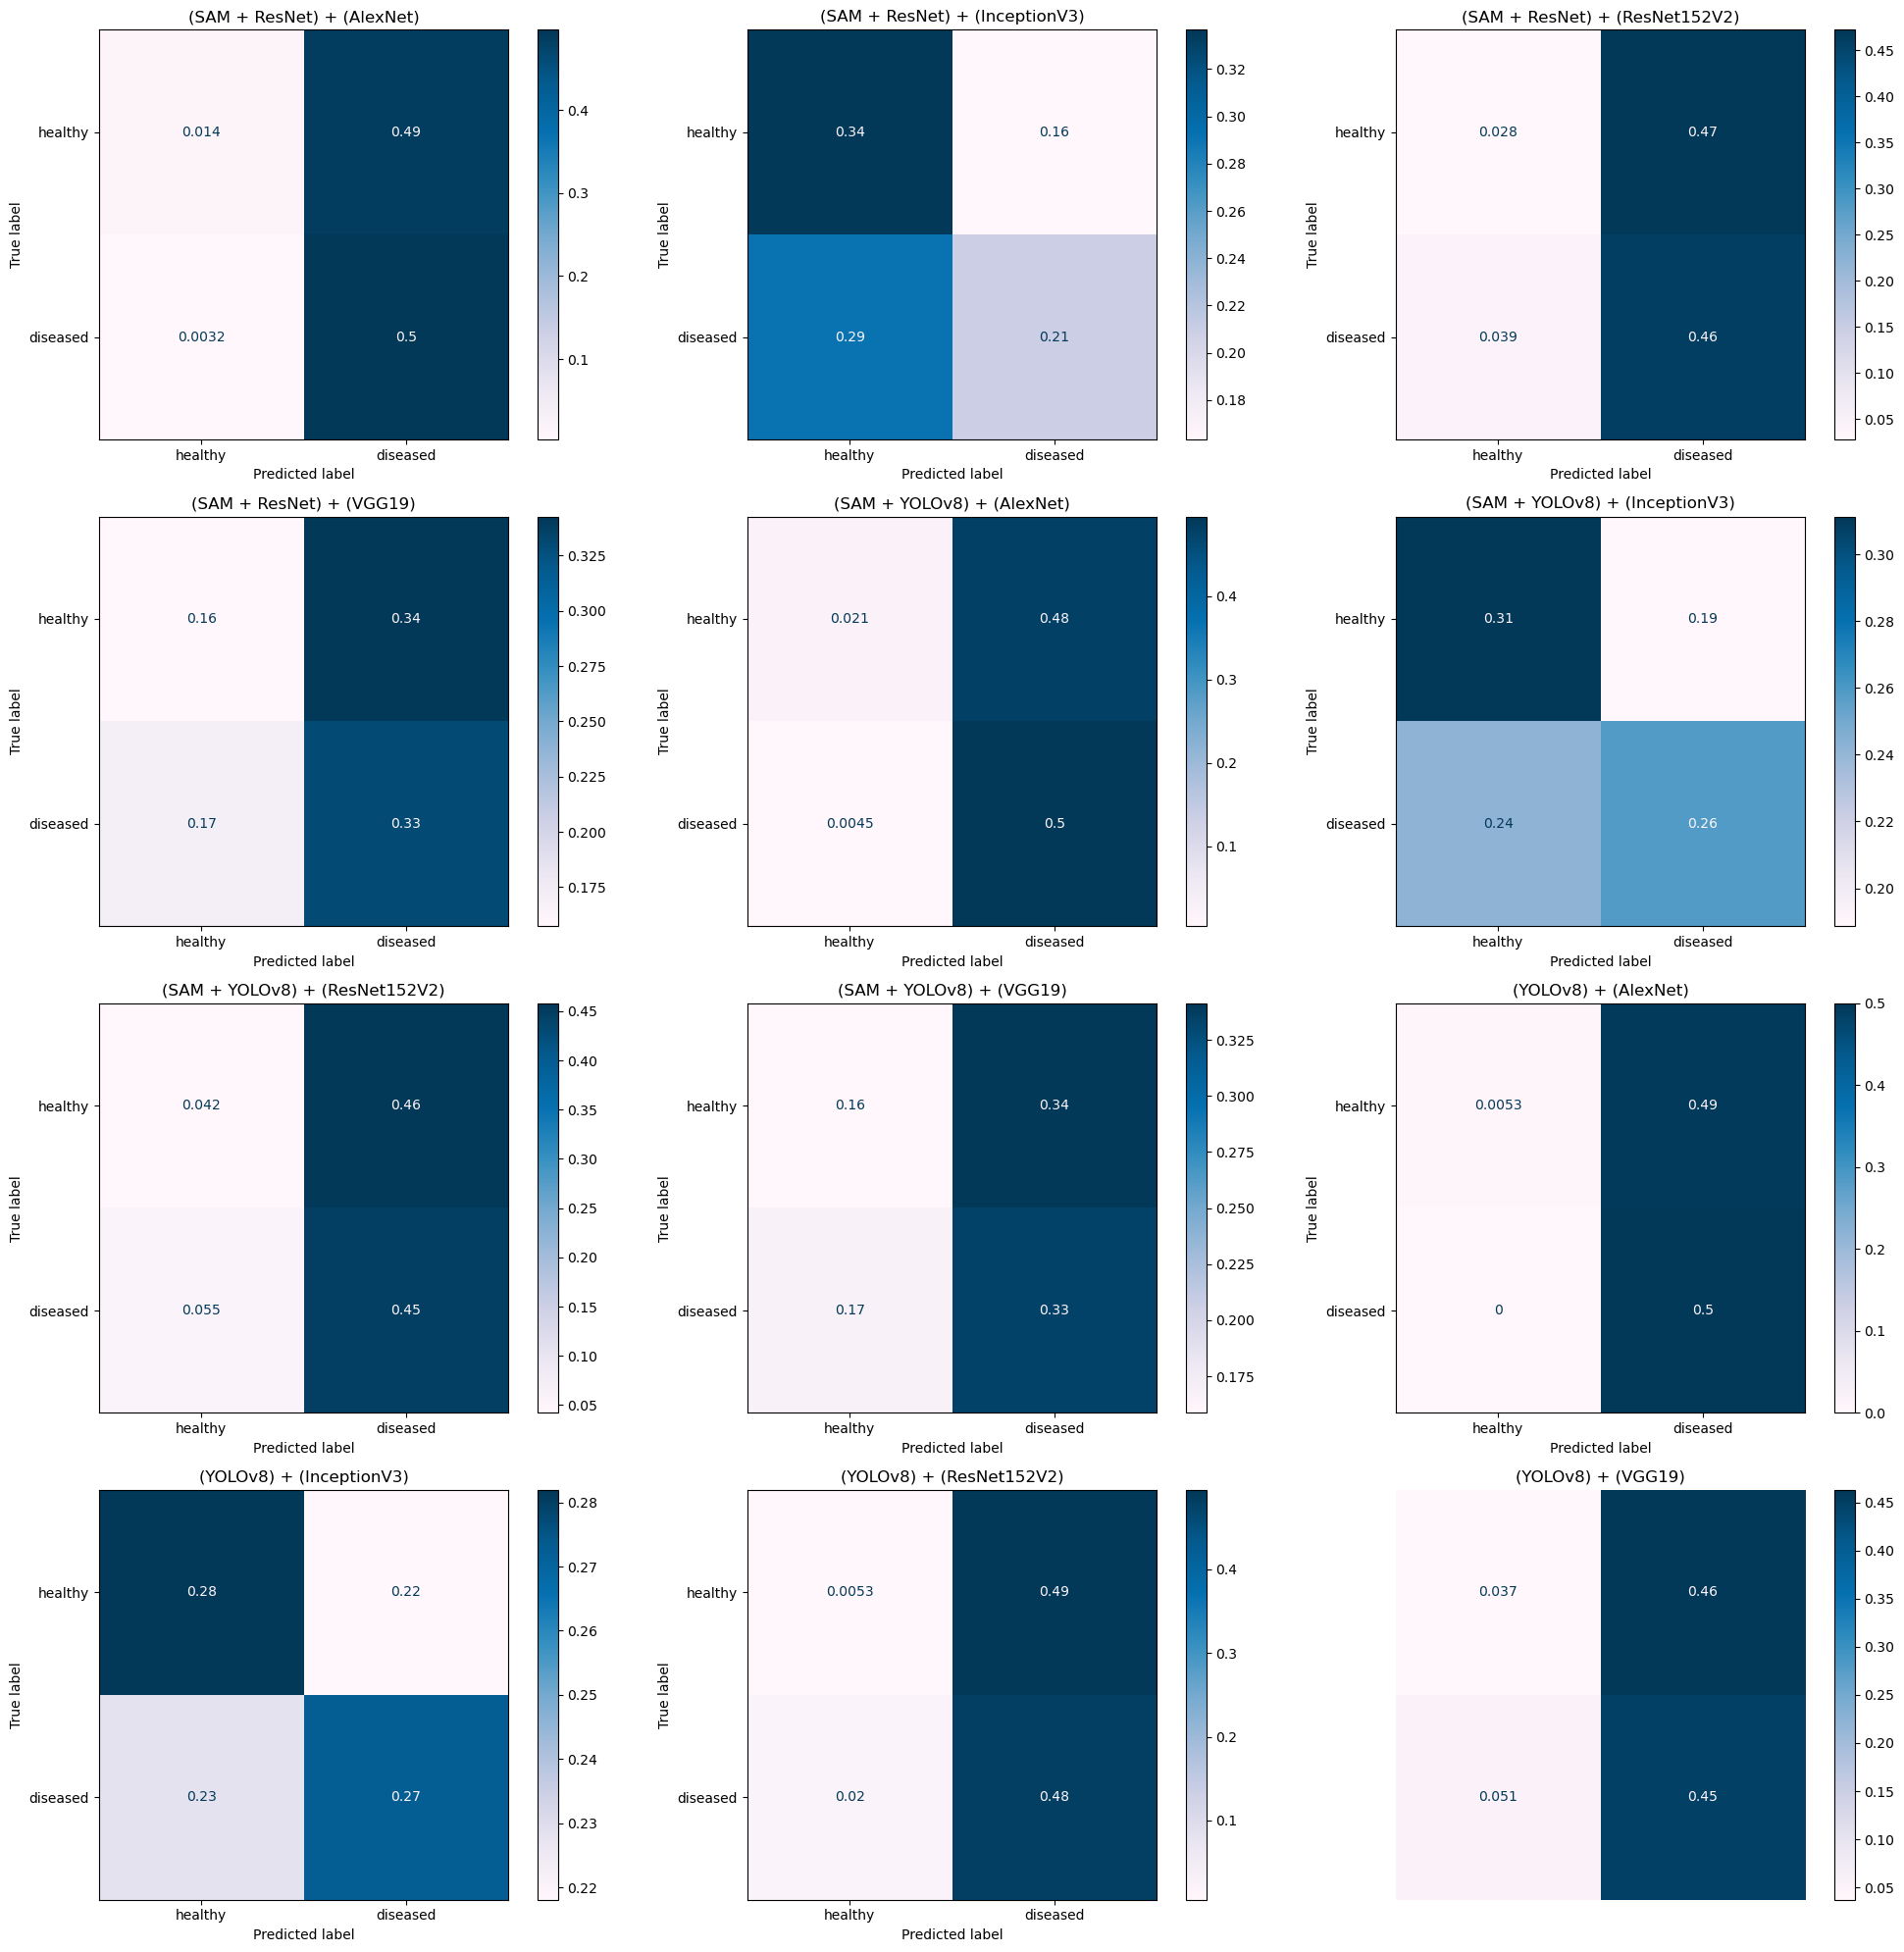

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
cols = 3
fig, axes = plt.subplots((len(results_conv) // cols), cols, figsize=(20, 20))
axes = axes.flatten()
axes[-1].axis('off')

for ax, (name, data) in zip(axes, sorted(results_conv.items())):
    total = len(data['y_true'])
    if total == 0:
        continue
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    disp = ConfusionMatrixDisplay.from_predictions(data['y_true'], data['y_pred'],
                                                   cmap="PuBu", 
                                                   ax=ax, 
                                                   sample_weight=sample_weight, 
                                                   normalize='all',
                                                   display_labels=["healthy", 'diseased'])
    disp.ax_.set_title(name)
plt.tight_layout()
plt.show()

In [71]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_auc_score
import pandas as pd

report_df = pd.DataFrame(columns=['precision', 'recall', 'f1-score', 'accuracy', 'auc'])

for name, data in results_conv.items():
    total = len(data['y_true'])
    unique, counts = np.unique(data['y_true'], return_counts=True)
    label_weights = 1 - (counts / total)
    sample_weight = np.array([label_weights[label] for label in data['y_true']])
    report = classification_report(data['y_true'], data['y_pred'], sample_weight=sample_weight, output_dict=True)['weighted avg']
    del report['support']
    report['accuracy'] = balanced_accuracy_score(data['y_true'], data['y_pred'], sample_weight=sample_weight)
    report['auc'] = roc_auc_score(data['y_true'], data['y_pred'])
    
    report_df.loc[name] = list(report.values())

In [72]:
report_df

,precision,recall,f1-score,accuracy,auc
(SAM + YOLOv8) + (InceptionV3),0.570522,0.569729,0.568516,0.569729,0.569729
(YOLOv8) + (VGG19),0.457167,0.486214,0.381327,0.486214,0.486214
(SAM + YOLOv8) + (ResNet152V2),0.463723,0.487350,0.387642,0.487350,0.487350
(YOLOv8) + (ResNet152V2),0.349504,0.484911,0.335425,0.484911,0.484911
(YOLOv8) + (AlexNet),0.751337,0.505319,0.345046,0.505319,0.505319
(SAM + ResNet) + (ResNet152V2),0.456498,0.489184,0.371039,0.489184,0.489184
(SAM + ResNet) + (VGG19),0.485855,0.487544,0.471771,0.487544,0.487544
(SAM + ResNet) + (InceptionV3),0.549162,0.545974,0.538491,0.545974,0.545974
(SAM + YOLOv8) + (AlexNet),0.666592,0.516504,0.375946,0.516504,0.516504
(SAM + YOLOv8) + (VGG19),0.491742,0.492758,0.476659,0.492758,0.492758


In [21]:
report_df.to_latex(float_format="%.4f")

'\\begin{tabular}{lrrrrr}\n\\toprule\n & precision & recall & f1-score & accuracy & auc \\\\\n\\midrule\n(SAM + YOLOv8) + (InceptionV3) & 0.5108 & 0.5097 & 0.4973 & 0.5097 & 0.5097 \\\\\n(YOLOv8) + (VGG19) & 0.5631 & 0.5327 & 0.4689 & 0.5327 & 0.5327 \\\\\n(SAM + YOLOv8) + (ResNet152V2) & 0.5473 & 0.5127 & 0.4038 & 0.5127 & 0.5127 \\\\\n(YOLOv8) + (ResNet152V2) & 0.5342 & 0.5080 & 0.3913 & 0.5080 & 0.5080 \\\\\n(YOLOv8) + (AlexNet) & 0.2477 & 0.4910 & 0.3293 & 0.4910 & 0.4910 \\\\\n(SAM + ResNet) + (ResNet152V2) & 0.5497 & 0.5132 & 0.4039 & 0.5132 & 0.5132 \\\\\n(SAM + ResNet) + (VGG19) & 0.5018 & 0.5018 & 0.5018 & 0.5018 & 0.5018 \\\\\n(SAM + ResNet) + (InceptionV3) & 0.5129 & 0.5116 & 0.4990 & 0.5116 & 0.5116 \\\\\n(SAM + YOLOv8) + (AlexNet) & 0.5515 & 0.5138 & 0.4049 & 0.5138 & 0.5138 \\\\\n(SAM + YOLOv8) + (VGG19) & 0.5024 & 0.5024 & 0.5024 & 0.5024 & 0.5024 \\\\\n(YOLOv8) + (InceptionV3) & 0.5634 & 0.5624 & 0.5606 & 0.5624 & 0.5624 \\\\\n(SAM + ResNet) + (AlexNet) & 0.5561 & 0.515

In [85]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
#scaled_df = pd.DataFrame(scaler.fit_transform(report_df), columns=report_df.columns, index=report_df.index)

# Step 4: Melt the DataFrame for seaborn
scaled_df_melted = report_df.reset_index().melt(id_vars='index', 
                                                var_name='Metric', 
                                                value_name='Scaled Value')
scaled_df_melted.rename(columns={'index': 'Pipeline'}, inplace=True)

In [86]:
scaled_df_melted

,Pipeline,Metric,Scaled Value
0,(SAM + YOLOv8) + (InceptionV3),precision,0.570522
1,(YOLOv8) + (VGG19),precision,0.457167
2,(SAM + YOLOv8) + (ResNet152V2),precision,0.463723
3,(YOLOv8) + (ResNet152V2),precision,0.349504
4,(YOLOv8) + (AlexNet),precision,0.751337
5,(SAM + ResNet) + (ResNet152V2),precision,0.456498
6,(SAM + ResNet) + (VGG19),precision,0.485855
7,(SAM + ResNet) + (InceptionV3),precision,0.549162
8,(SAM + YOLOv8) + (AlexNet),precision,0.666592
9,(SAM + YOLOv8) + (VGG19),precision,0.491742


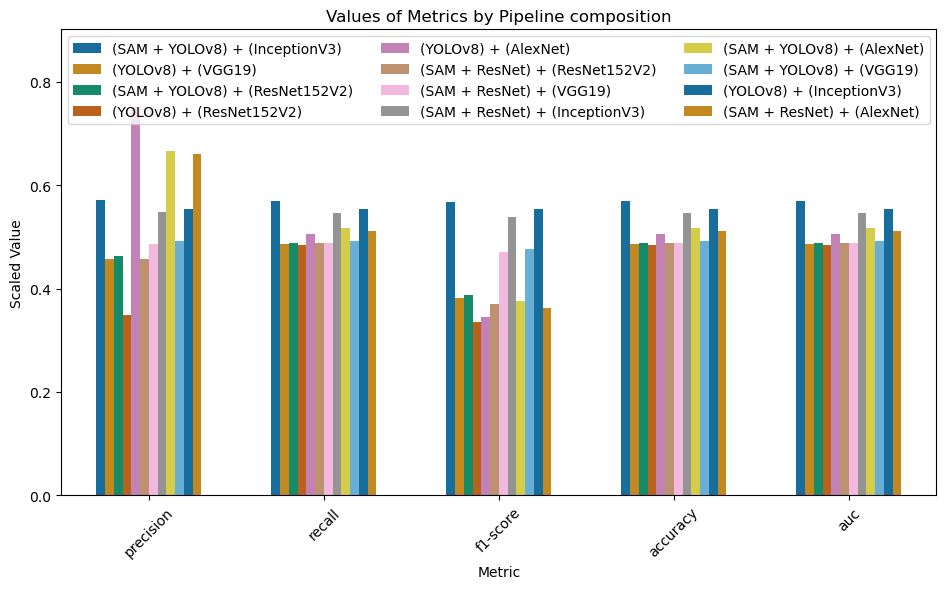

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Metric', y='Scaled Value', hue='Pipeline', data=scaled_df_melted, dodge=True, width=0.6, legend='brief', palette='colorblind')
ax.margins(y=.2)
ax.legend(ncol=3, loc='upper center')
plt.title('Values of Metrics by Pipeline composition')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

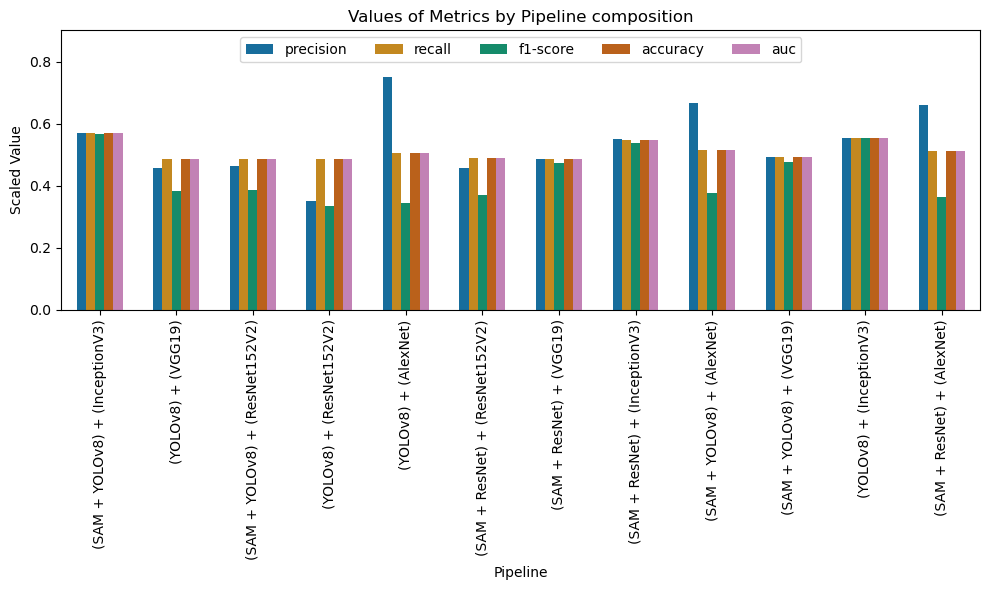

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Pipeline', y='Scaled Value', hue='Metric', data=scaled_df_melted, dodge=True, width=0.6, legend='brief', palette='colorblind')
ax.margins(y=.2)
ax.legend(ncol=5, loc='upper center')
plt.title('Values of Metrics by Pipeline composition')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()